The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Missing values in the dataset:
Missing timestamps: 1160
DatetimeIndex(['2025-03-15 00:01:00', '2025-03-15 00:02:00',
               '2025-03-15 00:03:00', '2025-03-15 00:04:00',
               '2025-03-15 00:05:00', '2025-03-15 00:06:00',
               '2025-03-15 00:07:00', '2025-03-15 00:08:00',
               '2025-03-15 00:09:00', '2025-03-15 00:10:00'],
              dtype='datetime64[ns]', freq='min')


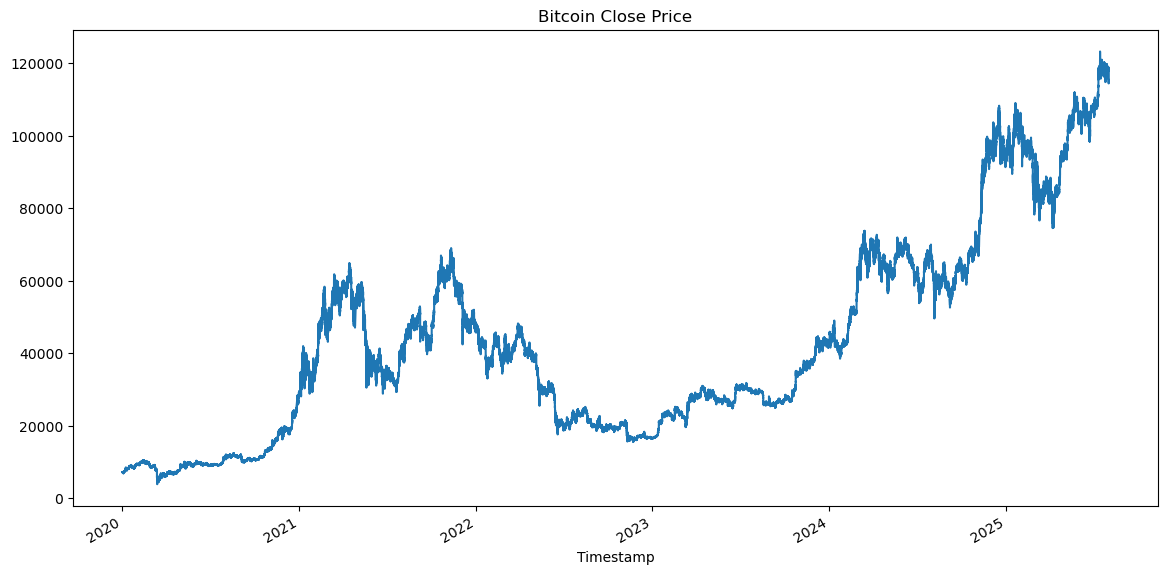

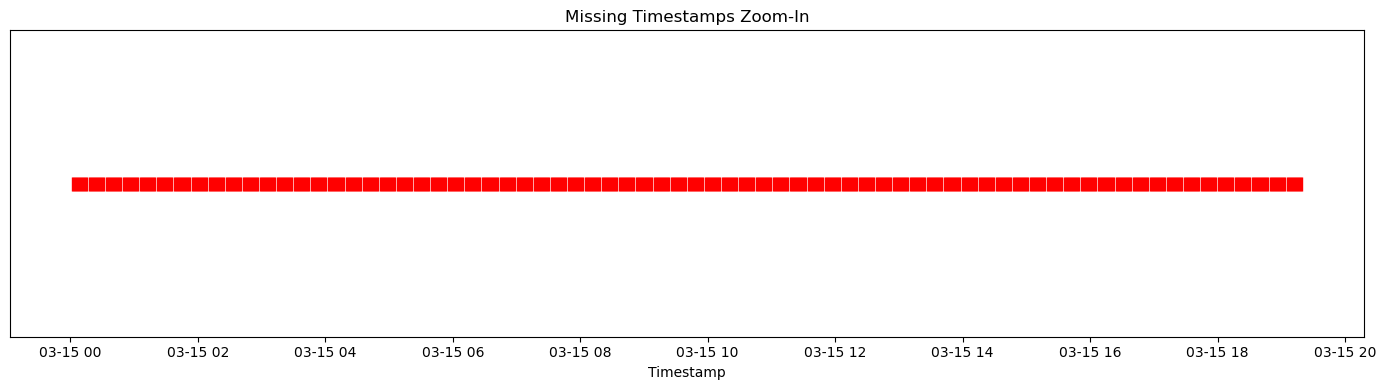

c:\Users\AYellowDuck\Desktop\2025summer\machine learning\project\Bitcoin_Price_Prediction\src\preprocessing.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.fillna(method=method)


Missing values in the dataset:
Missing timestamps: 0
DatetimeIndex([], dtype='datetime64[ns]', freq='min')


C:\Users\AYellowDuck\AppData\Local\Temp\ipykernel_14824\3291716712.py:70: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = bitstamp_filled['Close'].resample('1H').mean()


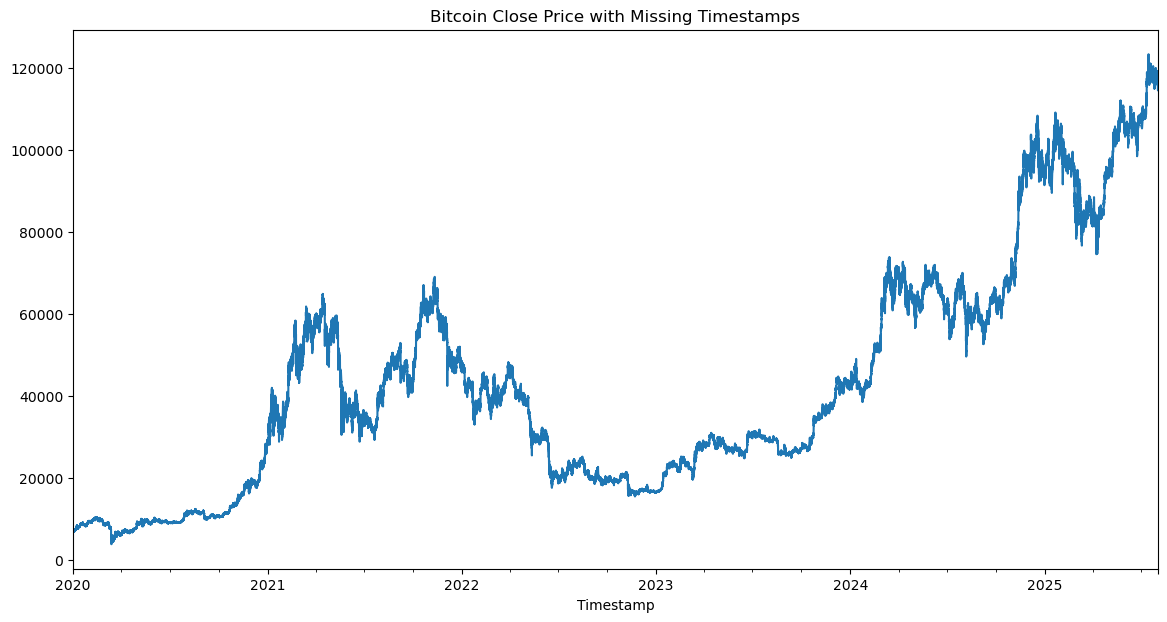

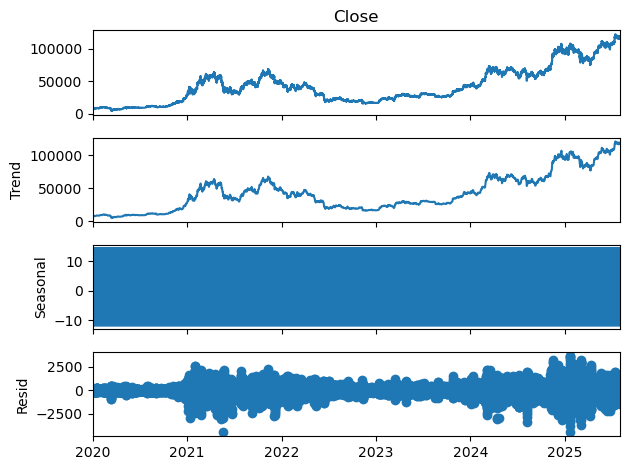

C:\Users\AYellowDuck\AppData\Local\Temp\ipykernel_14824\3291716712.py:82: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  bitstamp_filled['trend'] = trend.resample('1T').interpolate(method='time')


Open             0
High             0
Low              0
Close            0
Volume           0
trend            0
hour             0
dayofweek        0
hour_sin         0
hour_cos         0
dayofweek_sin    0
dayofweek_cos    0
dtype: int64
                         Open      High       Low     Close    Volume  \
Timestamp                                                               
2025-07-31 23:56:00  115643.0  115821.0  115643.0  115739.0  0.062538   
2025-07-31 23:57:00  115745.0  115768.0  115725.0  115768.0  0.312635   
2025-07-31 23:58:00  115772.0  115798.0  115720.0  115722.0  0.762144   
2025-07-31 23:59:00  115722.0  115759.0  115721.0  115750.0  0.060359   
2025-08-01 00:00:00  115749.0  115749.0  115699.0  115732.0  1.884059   

                             trend  hour  dayofweek  hour_sin  hour_cos  \
Timestamp                                                                 
2025-07-31 23:56:00  117905.900347    23          3 -0.258819  0.965926   
2025-07-31 23:57:00  1

In [3]:
# import pandas as pd
# from datetime import datetime
# bitstamp = pd.read_csv("btcusd_1-min_data.csv")
# bitstamp.info()
# bitstamp['Timestamp'] = pd.to_datetime(bitstamp['Timestamp'], unit='s')
# bitstamp.set_index('Timestamp', inplace=True)
# bitstamp.tail()
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.abspath("../../src"))
from preprocessing import *

# Load the data
bitstamp = dataload()

# Filter the data from 2020-01-01 to the last date available
bitstamp = data_filter(bitstamp, '2020-01-01', bitstamp.index[-1])

# Plotting the Close price
bitstamp.Close.plot(figsize=(14,7), title="Bitcoin Close Price")

#calculating missing values in the dataset
import matplotlib.pyplot as plt

# find missing values by checking for NaN values
missing_values = bitstamp.isnull().sum()
missing_per = (missing_values/bitstamp.shape[0])*100
missing_table = pd.concat([missing_values,missing_per], axis=1, ignore_index=True) 
missing_table.rename(columns={0:'Total Missing Values',1:'Missing %'}, inplace=True)
missing_table

# display the missing values
print("Missing values in the dataset:")
expected_range = pd.date_range(start=bitstamp.index.min(), end=bitstamp.index.max(), freq='1min')
missing_times = expected_range.difference(bitstamp.index)
print("Missing timestamps:", len(missing_times))
print(missing_times[:10])

# Plotting the missing timestamps
missing_df = pd.DataFrame(index=missing_times)
missing_df['Missing'] = 1
plt.figure(figsize=(14, 4))
plt.plot(missing_df.index, missing_df['Missing'], '|', color='red', markersize=10)
plt.title("Missing Timestamps Zoom-In")
plt.xlabel("Timestamp")
plt.yticks([]) 
plt.tight_layout()
plt.show()


bitstamp_full = add_missing_timestamps(bitstamp, freq='1min')
# Plotting the Close price with missing timestamps
bitstamp_full['Close'].plot(figsize=(14, 7), title="Bitcoin Close Price with Missing Timestamps")

# using forward fill to fill the missing values
bitstamp_filled = fill_missing_values(bitstamp_full, method='ffill')

# display the missing values after filling
print("Missing values in the dataset:")
expected_range = pd.date_range(start=bitstamp_filled.index.min(), end=bitstamp_filled.index.max(), freq='1min')
missing_times = expected_range.difference(bitstamp_filled.index)
print("Missing timestamps:", len(missing_times))
print(missing_times[:10])

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

df_hourly = bitstamp_filled['Close'].resample('1H').mean()

decomposition = seasonal_decompose(df_hourly.dropna(), model='additive', period=24)

decomposition.plot()
plt.tight_layout()
plt.show()

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

bitstamp_filled['trend'] = trend.resample('1T').interpolate(method='time')

import numpy as np

#Let the model learn the cyclical patterns of time-related features, rather than treating time as a linear variable.
bitstamp_filled['hour'] = bitstamp_filled.index.hour
bitstamp_filled['dayofweek'] = bitstamp_filled.index.dayofweek

bitstamp_filled['hour_sin'] = np.sin(2 * np.pi * bitstamp_filled['hour'] / 24)
bitstamp_filled['hour_cos'] = np.cos(2 * np.pi * bitstamp_filled['hour'] / 24)

bitstamp_filled['dayofweek_sin'] = np.sin(2 * np.pi * bitstamp_filled['dayofweek'] / 7)
bitstamp_filled['dayofweek_cos'] = np.cos(2 * np.pi * bitstamp_filled['dayofweek'] / 7)

bitstamp_filled = bitstamp_filled.dropna()
print(bitstamp_filled.isna().sum())
print(bitstamp_filled.tail())

#choose features
#bitstamp_selected = bitstamp_filled[['Close', 'trend', 'Volume', 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos']]
bitstamp_selected = bitstamp_filled[['Close', 'Volume', 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos']]

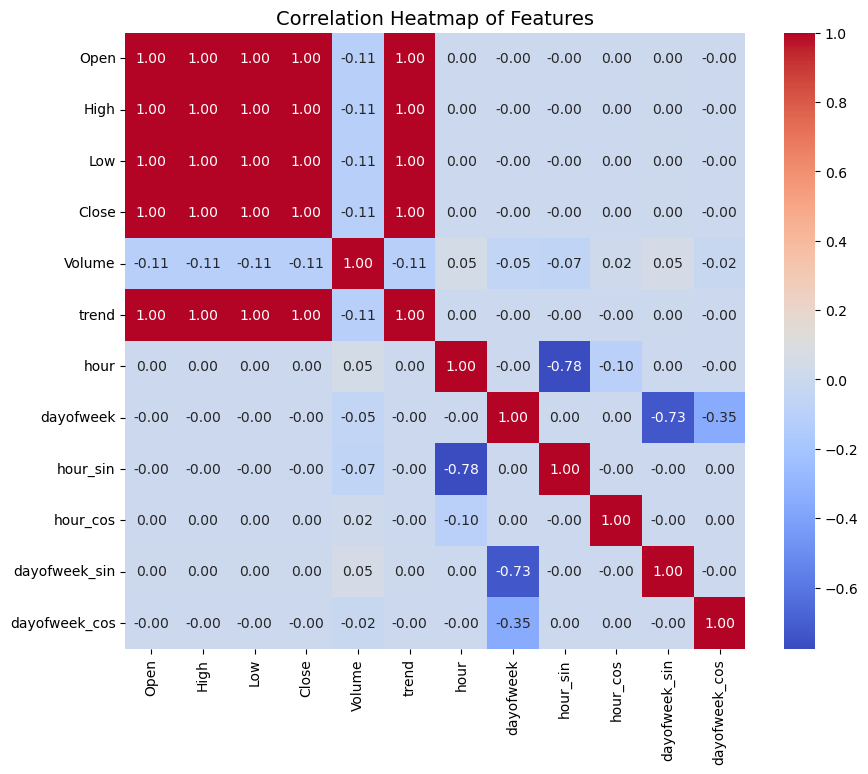

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


corr_matrix = bitstamp_filled.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Features", fontsize=14)
plt.show()

From time decomposition plot, we can find out:
The trend component closely resembles the original data, indicating that the trend dominates. 
The seasonal component appears as a flat bar, meaning no significant seasonal patterns were detected at this time scale (per-minute data).
Residuals fluctuate around the trend line, with greater noise observed around 2021 and late 2025, indicating more non-trend variability in those periods.
So trend was chosen as one feature. 

We did not include Open, High, and Low because their correlations with Close are almost 1, meaning they are essentially linear transformations of the same underlying price series and would introduce redundancy.
Instead, we kept Close as the representative price level, Trend as a smoothed version capturing long-term movement. To let the model learn the cyclical patterns of time-related features, rather than treating time as a linear variable. We use sine and cosine encoding to represent cyclical features such as hour of day and day of week.

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# normalization
scaler = MinMaxScaler()
bitstamp_scaled = pd.DataFrame(scaler.fit_transform(bitstamp_selected), 
                               columns=bitstamp_selected.columns, 
                               index=bitstamp_selected.index)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
import matplotlib.pyplot as plt

# 1st model, single-layer GRU
def build_gru_model(input_shape):
    model = Sequential([
        GRU(64, return_sequences=False, input_shape=input_shape),
        Dropout(0.2),
        Dense(1)  # next minute Close
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def evaluate_gru_model(model, X_test, y_test, scaler, start=0,n_plot=1000):
    y_pred = model.predict(X_test).flatten()

    # inverse normalization
    min_close = scaler.data_min_[0]
    max_close = scaler.data_max_[0]

    y_pred_real = y_pred * (max_close - min_close) + min_close
    y_test_real = y_test * (max_close - min_close) + min_close

    rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    mae = mean_absolute_error(y_test_real, y_pred_real)

    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")

    end = start + n_plot
    plt.figure(figsize=(12, 5))
    plt.plot(y_test_real[start:end], label='Actual Close')
    plt.plot(y_pred_real[start:end], label='Predicted Close')
    plt.title(f'GRU Prediction vs Actual (Samples {start} ~ {end})')
    plt.xlabel('Time Step')
    plt.ylabel('Close Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return rmse, mae


In [4]:
window_size = 30
data = bitstamp_scaled.values
X, y = [], []

for i in range(len(data) - window_size):
    X.append(data[i:i + window_size])
    y.append(data[i + window_size][0])

X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)

train_ratio = 0.8
train_size = int(len(X) * train_ratio)

X_train_gru = X[:train_size]
y_train_gru = y[:train_size]
X_test_gru = X[train_size:]
y_test_gru = y[train_size:]

(2935411, 30, 7) (2935411,)


d:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 88s 47ms/step - loss: 0.0037 - val_loss: 1.2183e-05
Epoch 2/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 86s 47ms/step - loss: 1.1149e-04 - val_loss: 2.9572e-06
Epoch 3/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 88s 48ms/step - loss: 8.4541e-05 - val_loss: 3.2226e-06
Epoch 4/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 95s 52ms/step - loss: 7.9632e-05 - val_loss: 1.1708e-05
Epoch 5/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 93s 51ms/step - loss: 7.7137e-05 - val_loss: 7.8379e-06
Epoch 6/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 93s 51ms/step - loss: 7.5062e-05 - val_loss: 1.1092e-06
Epoch 7/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 93s 50ms/step - loss: 7.3687e-05 - val_loss: 7.4300e-07
Epoch 8/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 93s 51ms/step - loss: 7.3295e-05 - val_loss: 3.7334e-06
Epoch 9/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 93s 51ms/step - loss: 7.2748e-05 - val_loss: 1.0191e-05
Epoch 10/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 92s 50ms/step - loss: 7.2373e-05 - val_loss: 1.1827e-06
Epoch 11/20
1835/1835 ━

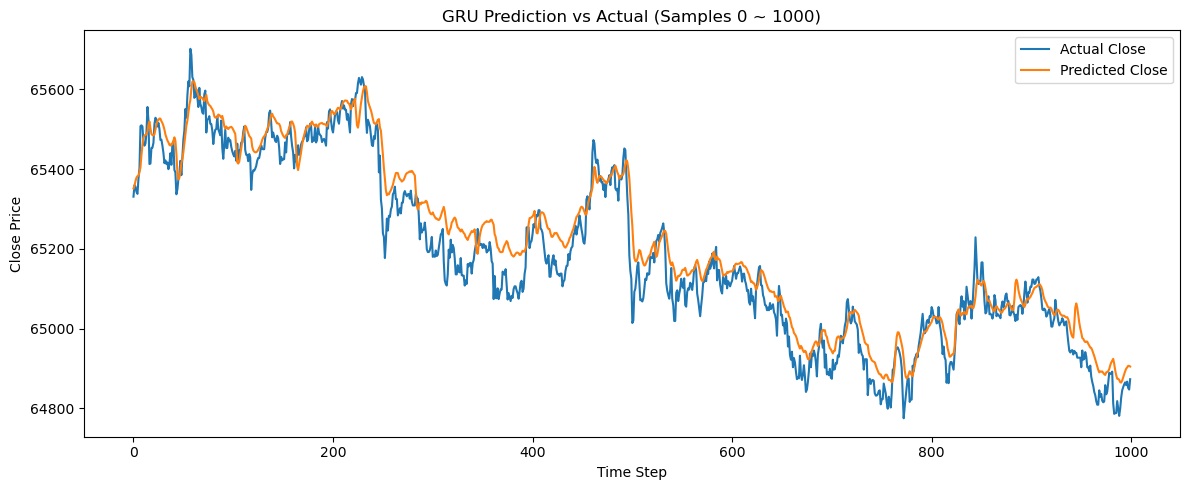

(898.8669721991527, 623.24631282837)

In [5]:

model_gru = build_gru_model(input_shape=(30, 7))

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_gru = model_gru.fit(
    X_train_gru, y_train_gru,
    epochs=20,
    batch_size=1024,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

#evaluate_gru_model(model_gru, X_test_gru, y_test_gru, scaler)
evaluate_gru_model(model_gru, X_test_gru, y_test_gru, scaler, start=0, n_plot=1000)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from tensorflow.keras import regularizers

#add layer 2
def build_gru_model_layer2(input_shape):
    model = Sequential([
        GRU(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        GRU(32, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

#change loss function mse->mae
def build_gru_model_layer1_lossmae(input_shape):
    model = Sequential([
        GRU(64, return_sequences=False, input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae')
    return model

# add L2
def build_gru_model_layer1_lossmae_L2(input_shape):
    model = Sequential([
        GRU(64, return_sequences=False, input_shape=input_shape,
            kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae')
    return model

# increase L2 0.001->0.002
def build_gru_model_layer1_lossmae_L2v2(input_shape):
    model = Sequential([
        GRU(64, return_sequences=False, input_shape=input_shape,
            kernel_regularizer=regularizers.l2(0.002)),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae')
    return model

d:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 174s 93ms/step - loss: 0.0016 - val_loss: 4.3604e-05
Epoch 2/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 176s 96ms/step - loss: 1.7491e-04 - val_loss: 2.5717e-05
Epoch 3/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 188s 102ms/step - loss: 1.5498e-04 - val_loss: 1.5753e-05
Epoch 4/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 172s 93ms/step - loss: 1.4842e-04 - val_loss: 2.4269e-05
Epoch 5/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 178s 97ms/step - loss: 1.4724e-04 - val_loss: 1.1022e-05
Epoch 6/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 178s 97ms/step - loss: 1.4569e-04 - val_loss: 4.2501e-06
Epoch 7/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 177s 97ms/step - loss: 1.4546e-04 - val_loss: 1.2882e-05
Epoch 8/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 2363s 1s/step - loss: 1.4540e-04 - val_loss: 2.1905e-06
Epoch 9/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 167s 91ms/step - loss: 1.4356e-04 - val_loss: 1.0675e-05
Epoch 10/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 176s 96ms/step - loss: 1.4331e-04 - val_loss: 6.6193e-06
Epoch 11/20
1

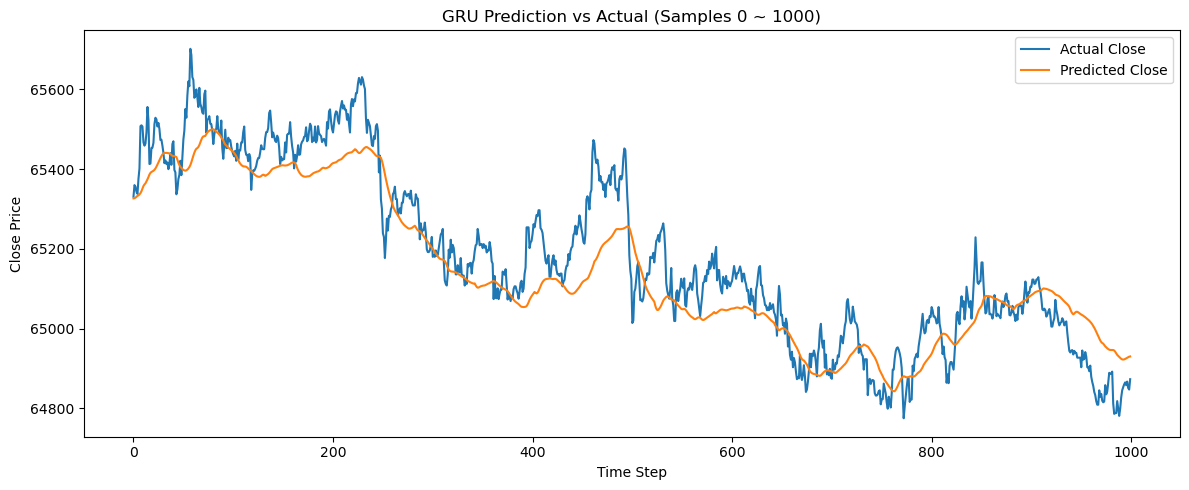

(2685.034605139111, 1863.1408790233872)

In [ ]:
# 2 layers GRU model
model_gru = build_gru_model_layer2(input_shape=(30, 7))

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_gru = model_gru.fit(
    X_train_gru, y_train_gru,
    epochs=20,
    batch_size=1024,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

evaluate_gru_model(model_gru, X_test_gru, y_test_gru, scaler, n_plot=1000)

d:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 91s 48ms/step - loss: 0.0249 - val_loss: 0.0016
Epoch 2/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 88s 48ms/step - loss: 0.0064 - val_loss: 0.0017
Epoch 3/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 88s 48ms/step - loss: 0.0061 - val_loss: 0.0067
Epoch 4/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 87s 47ms/step - loss: 0.0060 - val_loss: 0.0019
Epoch 5/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 86s 47ms/step - loss: 0.0059 - val_loss: 0.0015
Epoch 6/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 86s 47ms/step - loss: 0.0059 - val_loss: 0.0015
Epoch 7/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 85s 47ms/step - loss: 0.0058 - val_loss: 0.0019
Epoch 8/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 85s 46ms/step - loss: 0.0058 - val_loss: 0.0039
Epoch 9/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 86s 47ms/step - loss: 0.0057 - val_loss: 9.1571e-04
Epoch 10/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 86s 47ms/step - loss: 0.0057 - val_loss: 9.4392e-04
Epoch 11/20
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 5034s 3s/step - loss: 0.0057 - val_loss: 0.0017


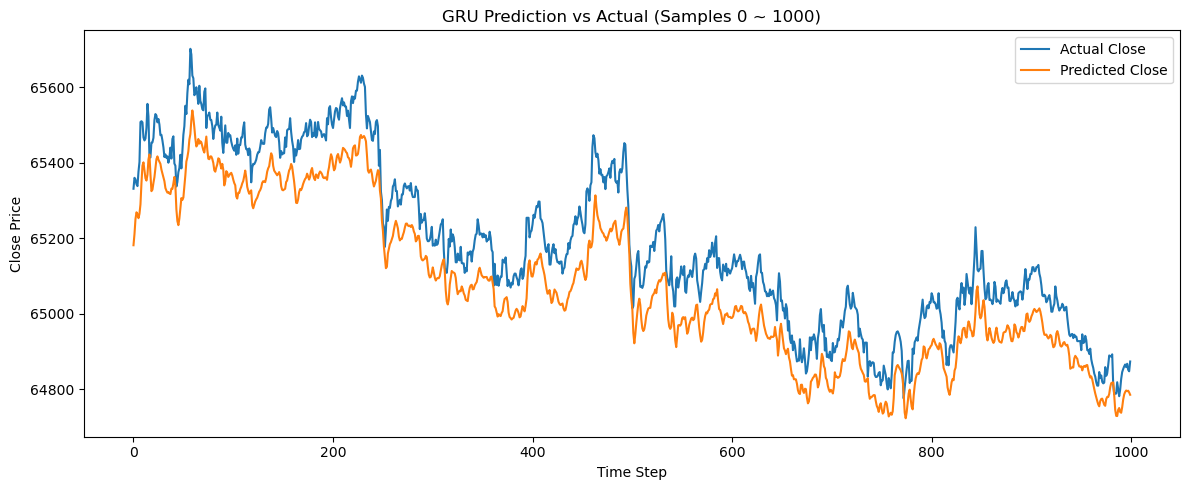

(757.8134314605336, 519.2071059972017)

In [ ]:
# 1 layer GRU model witn loss function mae
model_gru = build_gru_model_layer1_lossmae(input_shape=(30, 7))

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_gru = model_gru.fit(
    X_train_gru, y_train_gru,
    epochs=20,
    batch_size=1024,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

evaluate_gru_model(model_gru, X_test_gru, y_test_gru, scaler, n_plot=1000)

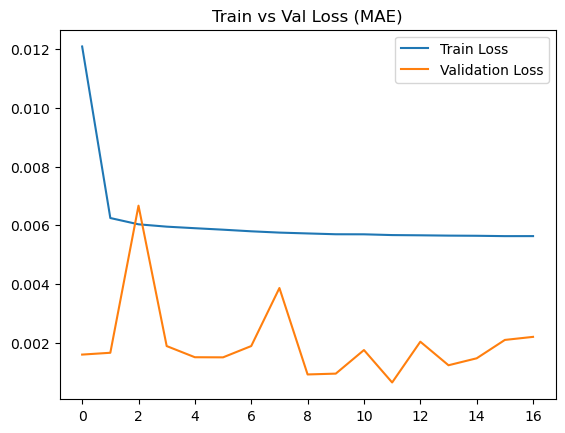

In [18]:
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Train vs Val Loss (MAE)")
plt.show()

In [ ]:
# some functions for saving model and performance data
def save_model_parameters(model_name, parameters, directory="parameters"):
    import os, json
    os.makedirs(directory, exist_ok=True)
    param_path = os.path.join(directory, f"{model_name}_params.json")
    with open(param_path, "w") as f:
        json.dump(parameters, f, indent=4)

def log_model_performance(model_name, metrics, log_file="performance/performance_log.csv"):
    import os, pandas as pd
    from datetime import datetime

    os.makedirs("performance", exist_ok=True)
    metrics["Model Name"] = model_name
    metrics["Timestamp"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    column_order = ["Timestamp", "Model Name"] + [col for col in metrics if col not in ["Timestamp", "Model Name"]]

    if not os.path.exists(log_file):
        df = pd.DataFrame(columns=column_order)
    else:
        df = pd.read_csv(log_file)

    new_row = pd.DataFrame([metrics])[column_order]
    df = pd.concat([df, new_row], ignore_index=True)

    df.to_csv(log_file, index=False)

model_gru.save(f"models/GRU_1layer_lossmae.h5")
save_model_parameters(
    model_name="GRU_1layer_lossmae",
    parameters={
        "window_size": 30,
        "loss": "mae",
        "gru_layers": 1,
        "Dense": 1,
        "units_per_layer": 64,
        "dropout": 0.2,
        "batch_size": 1024,
        "epochs": 20
    }
)
log_model_performance(
    model_name="GRU_1layer_lossmae",
    metrics={
        "RMSE": 757.81,
        "MAE": 519.29
    }
)



C:\Users\AYellowDuck\AppData\Local\Temp\ipykernel_4260\4237075189.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


d:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
7339/7339 ━━━━━━━━━━━━━━━━━━━━ 148s 20ms/step - loss: 0.0138 - val_loss: 0.0044
Epoch 2/50
7339/7339 ━━━━━━━━━━━━━━━━━━━━ 154s 21ms/step - loss: 0.0060 - val_loss: 0.0022
Epoch 3/50
7339/7339 ━━━━━━━━━━━━━━━━━━━━ 169s 23ms/step - loss: 0.0058 - val_loss: 7.8383e-04
Epoch 4/50
7339/7339 ━━━━━━━━━━━━━━━━━━━━ 170s 23ms/step - loss: 0.0058 - val_loss: 0.0037
Epoch 5/50
7339/7339 ━━━━━━━━━━━━━━━━━━━━ 170s 23ms/step - loss: 0.0057 - val_loss: 0.0024
Epoch 6/50
7339/7339 ━━━━━━━━━━━━━━━━━━━━ 3280s 447ms/step - loss: 0.0057 - val_loss: 0.0016
Epoch 7/50
7339/7339 ━━━━━━━━━━━━━━━━━━━━ 125s 17ms/step - loss: 0.0057 - val_loss: 0.0010
Epoch 8/50
7339/7339 ━━━━━━━━━━━━━━━━━━━━ 128s 17ms/step - loss: 0.0057 - val_loss: 0.0021
18347/18347 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step
RMSE: 412.9678
MAE : 319.6934


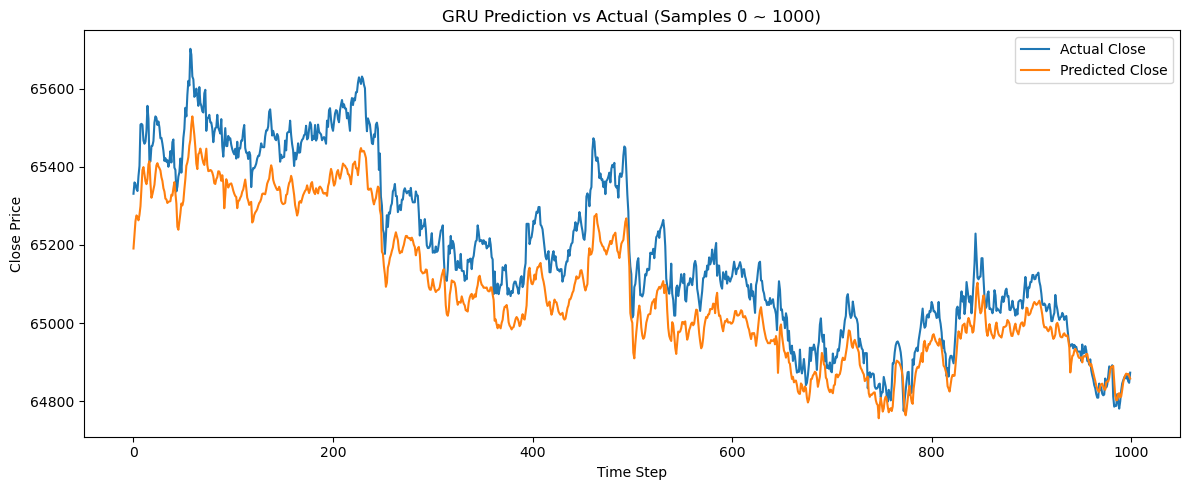

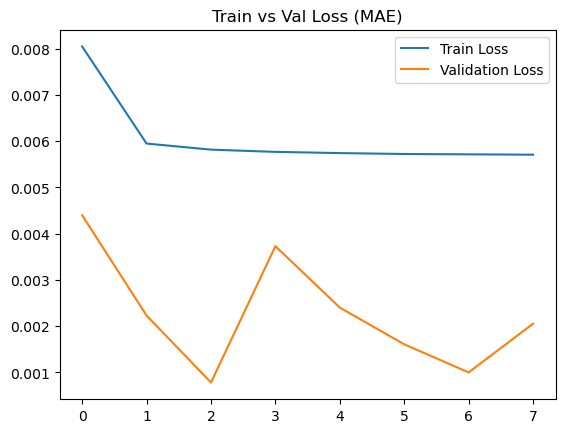

In [ ]:
# decrease batch size 1024->256
model_gru = build_gru_model_layer1_lossmae(input_shape=(30, 7))

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_gru = model_gru.fit(
    X_train_gru, y_train_gru,
    epochs=50,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

rmse_tmp, mae_tmp = evaluate_gru_model(model_gru, X_test_gru, y_test_gru, scaler, n_plot=1000)
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Train vs Val Loss (MAE)")
plt.show()

#save results
model_cur_name = "GRU_1layer_lossmae_batch256"
model_gru.save(f"models/{model_cur_name}.h5")
save_model_parameters(
    model_name=model_cur_name,
    parameters={
        "window_size": 30,
        "loss": "mae",
        "gru_layers": 1,
        "Dense": 1,
        "units_per_layer": 64,
        "dropout": 0.2,
        "batch_size": 256,
        "epochs": 50
    }
)
log_model_performance(
    model_name=model_cur_name,
    metrics={
        "RMSE": rmse_tmp,
        "MAE": mae_tmp
    }
)

d:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 175s 12ms/step - loss: 0.0115 - val_loss: 0.0056
Epoch 2/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 177s 12ms/step - loss: 0.0059 - val_loss: 0.0069
Epoch 3/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 189s 13ms/step - loss: 0.0058 - val_loss: 0.0031
Epoch 4/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 190s 13ms/step - loss: 0.0058 - val_loss: 0.0013
Epoch 5/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 190s 13ms/step - loss: 0.0058 - val_loss: 0.0025
Epoch 6/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 2347s 160ms/step - loss: 0.0058 - val_loss: 0.0042
Epoch 7/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 175s 12ms/step - loss: 0.0058 - val_loss: 0.0036
Epoch 8/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 189s 13ms/step - loss: 0.0058 - val_loss: 0.0049
Epoch 9/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 191s 13ms/step - loss: 0.0057 - val_loss: 0.0023
18347/18347 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step
RMSE: 342.3993
MAE : 305.1232


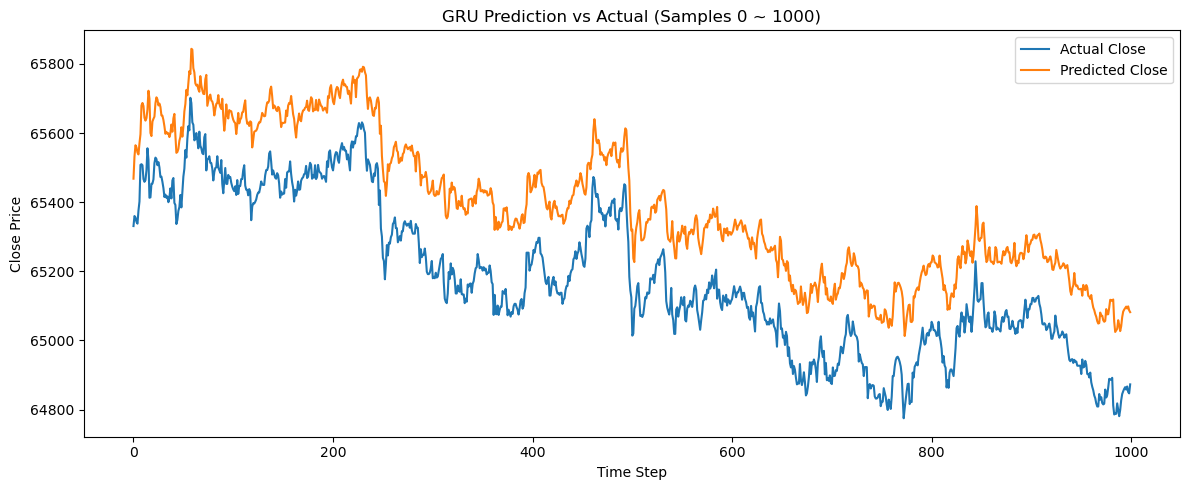

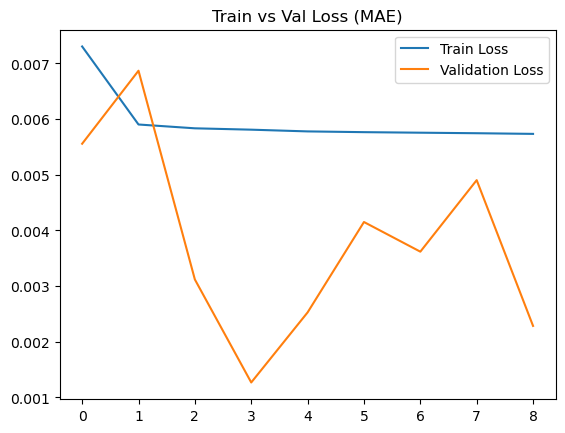

In [ ]:
# decrease batch size 256->128
model_gru = build_gru_model_layer1_lossmae(input_shape=(30, 7))

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_gru = model_gru.fit(
    X_train_gru, y_train_gru,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

rmse_tmp, mae_tmp = evaluate_gru_model(model_gru, X_test_gru, y_test_gru, scaler, n_plot=1000)
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Train vs Val Loss (MAE)")
plt.show()

#save results
model_cur_name = "GRU_1layer_lossmae_batch128"
model_gru.save(f"models/{model_cur_name}.h5")
save_model_parameters(
    model_name=model_cur_name,
    parameters={
        "window_size": 30,
        "loss": "mae",
        "gru_layers": 1,
        "Dense": 1,
        "units_per_layer": 64,
        "dropout": 0.2,
        "batch_size": 128,
        "epochs": 50
    }
)
log_model_performance(
    model_name=model_cur_name,
    metrics={
        "RMSE": rmse_tmp,
        "MAE": mae_tmp
    }
)

18347/18347 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step
[Corrected] RMSE: 163.0079
[Corrected] MAE : 127.9637


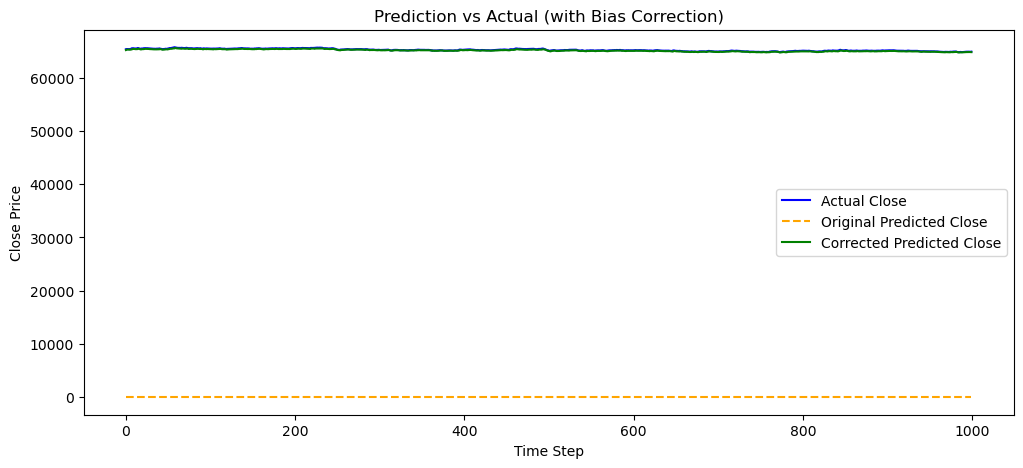

In [ ]:
# bias correction
y_pred = model_gru.predict(X_test_gru).flatten()

min_close = scaler.data_min_[0]
max_close = scaler.data_max_[0]
y_pred_real = y_pred * (max_close - min_close) + min_close
y_test_real = y_test_gru * (max_close - min_close) + min_close

bias = np.mean(y_test_real - y_pred_real)
y_pred_corrected = y_pred_real + bias


rmse_corrected = np.sqrt(mean_squared_error(y_test_real, y_pred_corrected))
mae_corrected = mean_absolute_error(y_test_real, y_pred_corrected)

print(f"[Corrected] RMSE: {rmse_corrected:.4f}")
print(f"[Corrected] MAE : {mae_corrected:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test_real[:1000], label='Actual Close', color='blue')
plt.plot(y_pred[:1000], label='Original Predicted Close', color='orange', linestyle='--')
plt.plot(y_pred_corrected[:1000], label='Corrected Predicted Close', color='green')
plt.title("Prediction vs Actual (with Bias Correction)")
plt.xlabel("Time Step")
plt.ylabel("Close Price")
plt.legend()
plt.show()

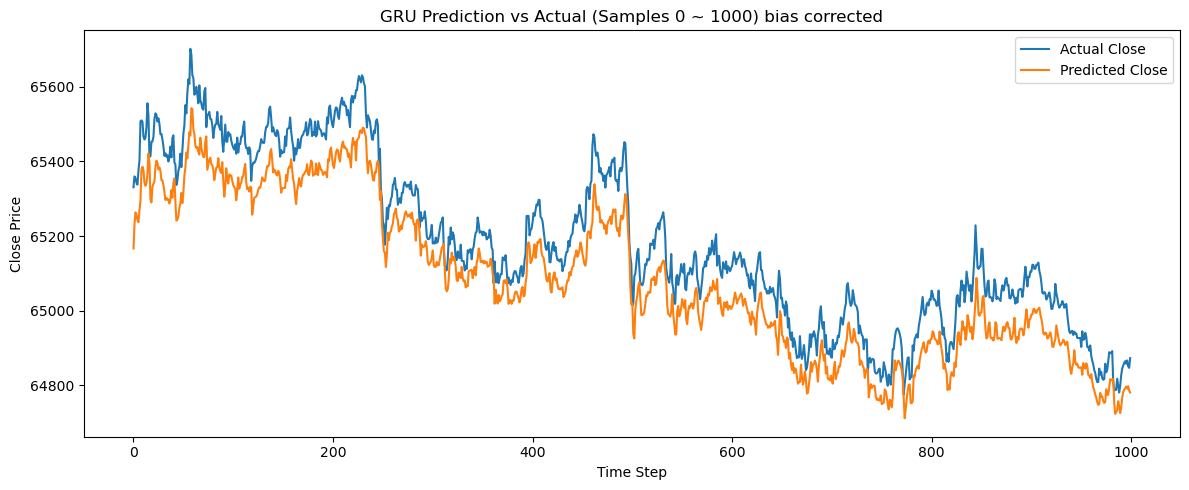

In [28]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_real[0:1000], label='Actual Close')
plt.plot(y_pred_corrected[0:1000], label='Predicted Close')
plt.title(f'GRU Prediction vs Actual (Samples 0 ~ 1000) bias corrected')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def evaluate_gru_model_addbias(model, X_test, y_test, scaler, start=0,n_plot=1000):
    y_pred = model_gru.predict(X_test_gru).flatten()

    min_close = scaler.data_min_[0]
    max_close = scaler.data_max_[0]
    y_pred_real = y_pred * (max_close - min_close) + min_close
    y_test_real = y_test_gru * (max_close - min_close) + min_close

    bias = np.mean(y_test_real - y_pred_real)
    y_pred_corrected = y_pred_real + bias


    rmse_corrected = np.sqrt(mean_squared_error(y_test_real, y_pred_corrected))
    mae_corrected = mean_absolute_error(y_test_real, y_pred_corrected)

    print(f"[Corrected] RMSE: {rmse_corrected:.4f}")
    print(f"[Corrected] MAE : {mae_corrected:.4f}")

    end = start + n_plot
    plt.figure(figsize=(12, 5))
    plt.plot(y_test_real[start:end], label='Actual Close')
    plt.plot(y_pred_real[start:end], label='Predicted Close')
    plt.title(f'GRU Prediction vs Actual (Samples {start} ~ {end}) add bias')
    plt.xlabel('Time Step')
    plt.ylabel('Close Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return rmse_corrected, mae_corrected

d:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 177s 12ms/step - loss: 0.0032 - val_loss: 5.1850e-04
Epoch 2/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 188s 13ms/step - loss: 1.7605e-04 - val_loss: 3.1402e-04
Epoch 3/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 194s 13ms/step - loss: 1.7375e-04 - val_loss: 3.8133e-04
Epoch 4/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 194s 13ms/step - loss: 1.7531e-04 - val_loss: 2.0747e-04
Epoch 5/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 936s 64ms/step - loss: 1.7331e-04 - val_loss: 3.1911e-04
Epoch 6/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 207s 14ms/step - loss: 1.7423e-04 - val_loss: 2.4047e-04
Epoch 7/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 193s 13ms/step - loss: 1.7362e-04 - val_loss: 2.7560e-04
Epoch 8/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 190s 13ms/step - loss: 1.7425e-04 - val_loss: 1.6687e-04
Epoch 9/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 189s 13ms/step - loss: 1.7316e-04 - val_loss: 3.2398e-04
Epoch 10/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 188s 13ms/step - loss: 1.7408e-04 - val_loss: 2.74

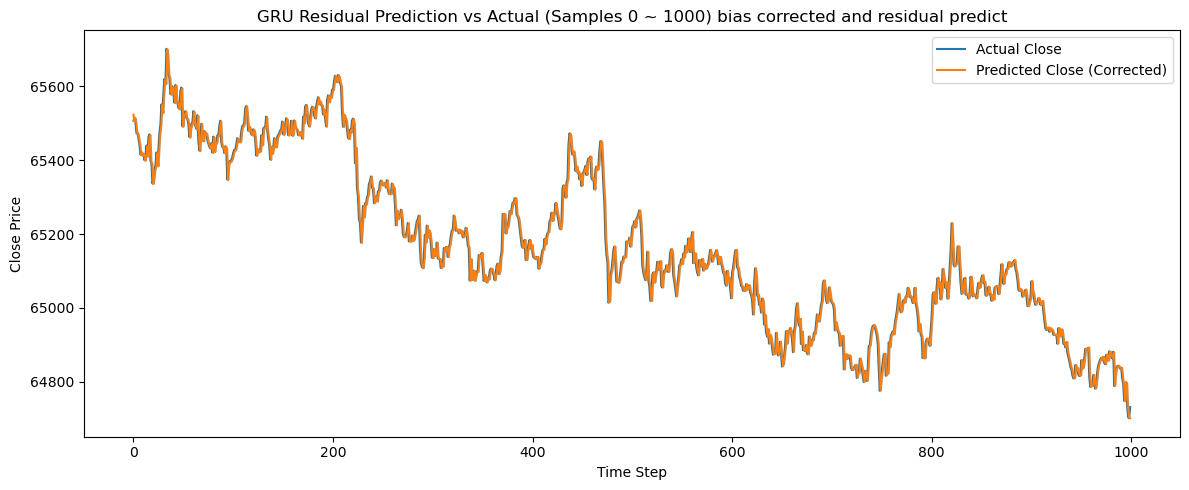

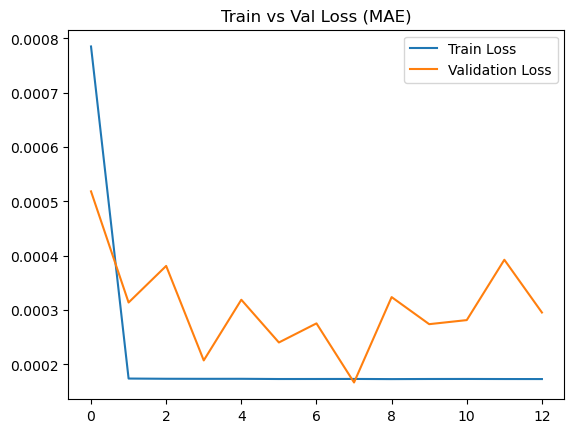

In [ ]:
#Predicting price changes (residuals) model
split_index = int(len(bitstamp_scaled) * 0.8)

train_scaled = bitstamp_scaled.iloc[:split_index].values
test_scaled = bitstamp_scaled.iloc[split_index:].values

def create_sliding_window_residual(data, window_size=30, close_index=0):
    X, y = [], []
    for i in range(len(data) - window_size):
        window = data[i:i + window_size]
        close_t = data[i + window_size][close_index]
        close_t_1 = data[i + window_size - 1][close_index]
        y.append(close_t - close_t_1)
        X.append(window)
    return np.array(X), np.array(y)

def evaluate_gru_model_residual(model, X_test, y_test, scaler, close_index=0, start=0, n_plot=1000):
    y_pred_residual = model.predict(X_test).flatten()

    last_close_norm = X_test[:, -1, close_index]
    y_pred_norm = y_pred_residual + last_close_norm
    y_test_norm = y_test + last_close_norm

    min_close = scaler.data_min_[close_index]
    max_close = scaler.data_max_[close_index]

    y_pred_real = y_pred_norm * (max_close - min_close) + min_close
    y_test_real = y_test_norm * (max_close - min_close) + min_close

    bias = np.mean(y_test_real - y_pred_real)
    y_pred_corrected = y_pred_real + bias

    rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_corrected))
    mae = mean_absolute_error(y_test_real, y_pred_corrected)

    print(f"[Corrected] RMSE: {rmse:.2f}")
    print(f"[Corrected] MAE : {mae:.2f}")

    end = start + n_plot
    plt.figure(figsize=(12, 5))
    plt.plot(y_test_real[start:end], label='Actual Close')
    plt.plot(y_pred_corrected[start:end], label='Predicted Close (Corrected)')
    plt.title(f'GRU Residual Prediction vs Actual (Samples {start} ~ {end}) bias corrected and residual predict')
    plt.xlabel('Time Step')
    plt.ylabel('Close Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return rmse, mae


close_index = 0
X_train_gru_residual, y_train_gru_residual = create_sliding_window_residual(train_scaled, window_size=30, close_index=0)
X_test_gru_residual, y_test_gru_residual = create_sliding_window_residual(test_scaled, window_size=30, close_index=0)

model_gru_residual = build_gru_model_layer1_lossmae(input_shape=(30, train_scaled.shape[1]))

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_gru_residual = model_gru_residual.fit(
    X_train_gru_residual, y_train_gru_residual,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

rmse_tmp, mae_tmp = evaluate_gru_model_residual(
    model_gru_residual, 
    X_test_gru_residual, 
    y_test_gru_residual, 
    scaler, 
    close_index=0,
    n_plot=1000
)
plt.plot(history_gru_residual.history['loss'], label='Train Loss')
plt.plot(history_gru_residual.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Train vs Val Loss (MAE)")
plt.show()

#save results
model_cur_name = "GRU_1layer_lossmae_batch128_BiascorrectedandResidual"
model_gru_residual.save(f"models/{model_cur_name}.h5")
save_model_parameters(
    model_name=model_cur_name,
    parameters={
        "window_size": 30,
        "loss": "mae",
        "gru_layers": 1,
        "Dense": 1,
        "units_per_layer": 64,
        "dropout": 0.2,
        "batch_size": 128,
        "epochs": 50
    }
)
log_model_performance(
    model_name=model_cur_name,
    metrics={
        "RMSE": rmse_tmp,
        "MAE": mae_tmp
    }
)

Predicting price changes (residuals) is easier to learn than predicting absolute prices, as the changes are more stationary, exhibit stronger patterns, and result in smaller errors. Combined with a bias correction mechanism, this approach can effectively recover the actual price levels, leading to improved overall model performance (e.g., lower MAE and RMSE).

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# split dataset first
split_index = int(len(bitstamp_selected) * 0.8)
train_raw = bitstamp_selected.iloc[:split_index]
test_raw = bitstamp_selected.iloc[split_index:]

scaler = MinMaxScaler()
train_scaled2 = scaler.fit_transform(train_raw.values)
test_scaled2 = scaler.transform(test_raw.values)

def create_sliding_window_residual_splitfirst2(data, window_size=30, close_index=0):
    X, y = [], []
    for i in range(len(data) - window_size):
        window = data[i:i + window_size]
        close_t = data[i + window_size][close_index]
        close_t_1 = data[i + window_size - 1][close_index]
        y.append(close_t - close_t_1)
        X.append(window)
    return np.array(X), np.array(y)

close_index = 0
X_train_gru_residual, y_train_gru_residual = create_sliding_window_residual_splitfirst2(train_scaled2, window_size=30, close_index=0)
X_test_gru_residual, y_test_gru_residual = create_sliding_window_residual_splitfirst2(test_scaled2, window_size=30, close_index=0)

model_gru_residual = build_gru_model_layer1_lossmae(input_shape=(30, train_scaled2.shape[1]))

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_gru_residual = model_gru_residual.fit(
    X_train_gru_residual, y_train_gru_residual,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

rmse_tmp, mae_tmp = evaluate_gru_model_residual(
    model_gru_residual, 
    X_test_gru_residual, 
    y_test_gru_residual, 
    scaler, 
    close_index=0,
    n_plot=1000
)
plt.plot(history_gru_residual.history['loss'], label='Train Loss')
plt.plot(history_gru_residual.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Train vs Val Loss (MAE)")
plt.show()

#save results
model_cur_name = "GRU_1layer_lossmae_batch128_BiascorrectedandResidual_splitfirst"
model_gru_residual.save(f"models/{model_cur_name}.h5")
save_model_parameters(
    model_name=model_cur_name,
    parameters={
        "window_size": 30,
        "loss": "mae",
        "gru_layers": 1,
        "Dense": 1,
        "units_per_layer": 64,
        "dropout": 0.2,
        "batch_size": 128,
        "epochs": 50
    }
)
log_model_performance(
    model_name=model_cur_name,
    metrics={
        "RMSE": rmse_tmp,
        "MAE": mae_tmp
    }
)

d:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 165s 11ms/step - loss: 0.0045 - val_loss: 4.2996e-04
Epoch 2/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 171s 12ms/step - loss: 2.8607e-04 - val_loss: 3.1159e-04
Epoch 3/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 190s 13ms/step - loss: 2.8415e-04 - val_loss: 6.1859e-04
Epoch 4/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 190s 13ms/step - loss: 2.8576e-04 - val_loss: 5.0356e-04
Epoch 5/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 189s 13ms/step - loss: 2.8522e-04 - val_loss: 3.4019e-04
Epoch 6/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 1146s 78ms/step - loss: 2.8438e-04 - val_loss: 3.4961e-04
Epoch 7/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 190s 13ms/step - loss: 2.8465e-04 - val_loss: 5.5830e-04


NameError: name 'evaluate_gru_model_residual' is not defined

18346/18346 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step
[Corrected] RMSE: 58.05
[Corrected] MAE : 35.49


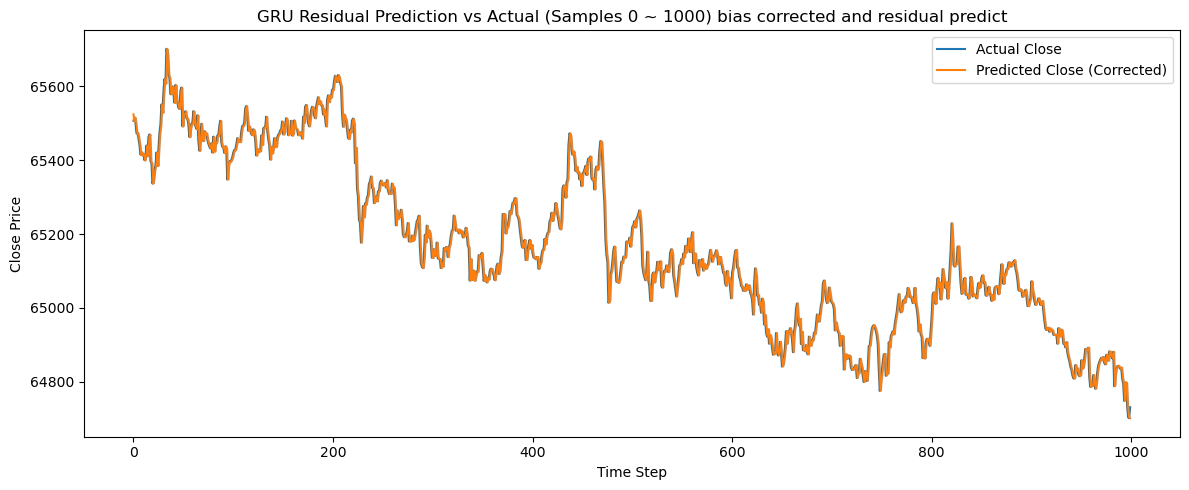

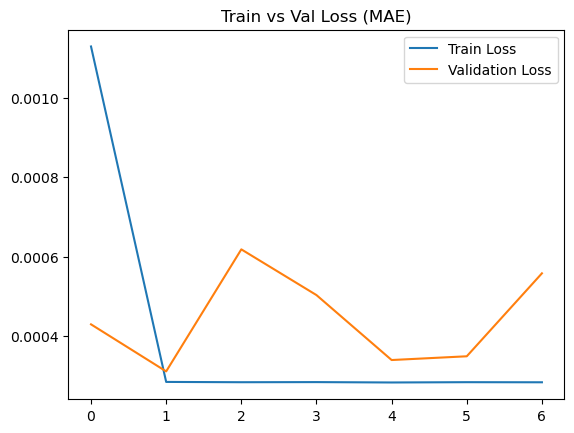

In [ ]:
def evaluate_gru_model_residual(model, X_test, y_test, scaler, close_index=0, start=0, n_plot=1000):
    y_pred_residual = model.predict(X_test).flatten()

    last_close_norm = X_test[:, -1, close_index]
    y_pred_norm = y_pred_residual + last_close_norm
    y_test_norm = y_test + last_close_norm

    min_close = scaler.data_min_[close_index]
    max_close = scaler.data_max_[close_index]

    y_pred_real = y_pred_norm * (max_close - min_close) + min_close
    y_test_real = y_test_norm * (max_close - min_close) + min_close


    bias = np.mean(y_test_real - y_pred_real)
    y_pred_corrected = y_pred_real + bias

    rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_corrected))
    mae = mean_absolute_error(y_test_real, y_pred_corrected)

    print(f"[Corrected] RMSE: {rmse:.2f}")
    print(f"[Corrected] MAE : {mae:.2f}")

    end = start + n_plot
    plt.figure(figsize=(12, 5))
    plt.plot(y_test_real[start:end], label='Actual Close')
    plt.plot(y_pred_corrected[start:end], label='Predicted Close (Corrected)')
    plt.title(f'GRU Residual Prediction vs Actual (Samples {start} ~ {end}) bias corrected and residual predict')
    plt.xlabel('Time Step')
    plt.ylabel('Close Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return rmse, mae

def save_model_parameters(model_name, parameters, directory="parameters"):
    import os, json
    os.makedirs(directory, exist_ok=True)
    param_path = os.path.join(directory, f"{model_name}_params.json")
    with open(param_path, "w") as f:
        json.dump(parameters, f, indent=4)

def log_model_performance(model_name, metrics, log_file="performance/performance_log.csv"):
    import os, pandas as pd
    from datetime import datetime

    os.makedirs("performance", exist_ok=True)
    metrics["Model Name"] = model_name
    metrics["Timestamp"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    column_order = ["Timestamp", "Model Name"] + [col for col in metrics if col not in ["Timestamp", "Model Name"]]

    if not os.path.exists(log_file):
        df = pd.DataFrame(columns=column_order)
    else:
        df = pd.read_csv(log_file)

    new_row = pd.DataFrame([metrics])[column_order]
    df = pd.concat([df, new_row], ignore_index=True)

    df.to_csv(log_file, index=False)

rmse_tmp, mae_tmp = evaluate_gru_model_residual(
    model_gru_residual, 
    X_test_gru_residual, 
    y_test_gru_residual, 
    scaler, 
    close_index=0,
    n_plot=1000
)
plt.plot(history_gru_residual.history['loss'], label='Train Loss')
plt.plot(history_gru_residual.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Train vs Val Loss (MAE)")
plt.show()

#save results
model_cur_name = "GRU_1layer_lossmae_batch128_BiascorrectedandResidual_splitfirst"
model_gru_residual.save(f"models/{model_cur_name}.h5")
save_model_parameters(
    model_name=model_cur_name,
    parameters={
        "window_size": 30,
        "loss": "mae",
        "gru_layers": 1,
        "Dense": 1,
        "units_per_layer": 64,
        "dropout": 0.2,
        "batch_size": 128,
        "epochs": 50
    }
)
log_model_performance(
    model_name=model_cur_name,
    metrics={
        "RMSE": rmse_tmp,
        "MAE": mae_tmp
    }
)

d:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 167s 11ms/step - loss: 0.0057 - val_loss: 6.1578e-04
Epoch 2/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 167s 11ms/step - loss: 2.8576e-04 - val_loss: 3.4567e-04
Epoch 3/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 185s 13ms/step - loss: 2.8330e-04 - val_loss: 4.5298e-04
Epoch 4/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 185s 13ms/step - loss: 2.8394e-04 - val_loss: 5.0933e-04
Epoch 5/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 185s 13ms/step - loss: 2.8440e-04 - val_loss: 3.4952e-04
Epoch 6/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 5158s 351ms/step - loss: 2.8490e-04 - val_loss: 4.1105e-04
Epoch 7/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 163s 11ms/step - loss: 2.8467e-04 - val_loss: 5.9345e-04
18346/18346 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step
[Corrected] RMSE: 58.05
[Corrected] MAE : 35.47


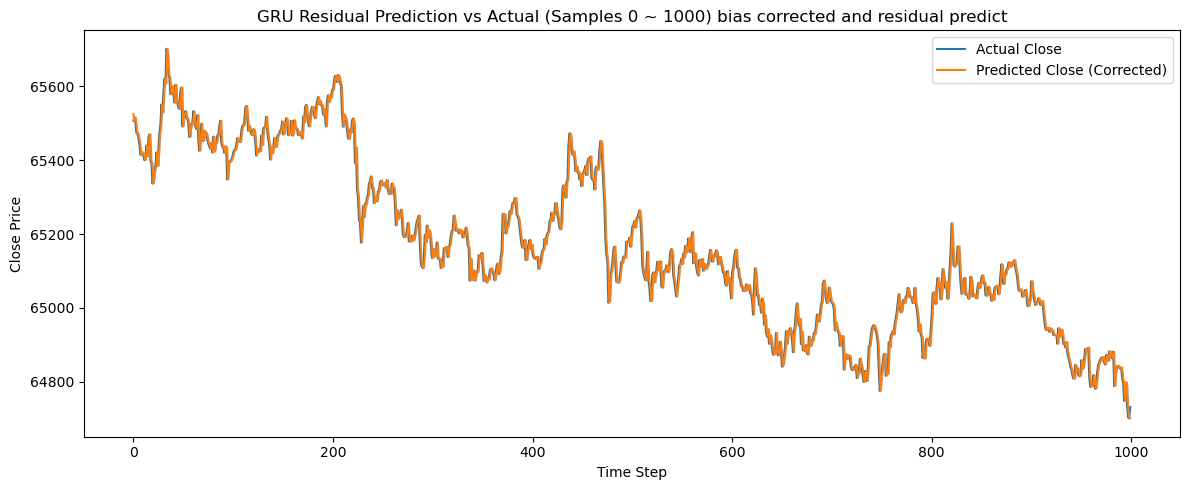

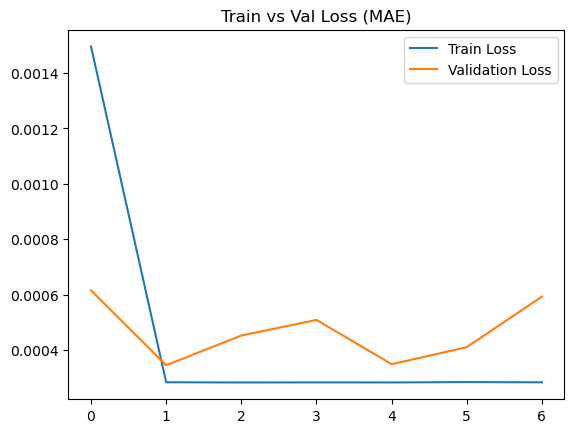

In [ ]:
# add L2
model_gru_residual = build_gru_model_layer1_lossmae_L2(input_shape=(30, train_scaled2.shape[1]))

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_gru_residual = model_gru_residual.fit(
    X_train_gru_residual, y_train_gru_residual,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

rmse_tmp, mae_tmp = evaluate_gru_model_residual(
    model_gru_residual, 
    X_test_gru_residual, 
    y_test_gru_residual, 
    scaler, 
    close_index=0,
    n_plot=1000
)
plt.plot(history_gru_residual.history['loss'], label='Train Loss')
plt.plot(history_gru_residual.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Train vs Val Loss (MAE)")
plt.show()

#save results
model_cur_name = "GRU_1layer_lossmae_batch128_BiascorrectedandResidual_splitfirst_L2"
model_gru_residual.save(f"models/{model_cur_name}.h5")
save_model_parameters(
    model_name=model_cur_name,
    parameters={
        "window_size": 30,
        "loss": "mae",
        "gru_layers": 1,
        "Dense": 1,
        "units_per_layer": 64,
        "dropout": 0.2,
        "batch_size": 128,
        "epochs": 50
    }
)
log_model_performance(
    model_name=model_cur_name,
    metrics={
        "RMSE": rmse_tmp,
        "MAE": mae_tmp
    }
)

d:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 167s 11ms/step - loss: 0.0062 - val_loss: 5.5613e-04
Epoch 2/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 174s 12ms/step - loss: 2.8596e-04 - val_loss: 3.5067e-04
Epoch 3/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 187s 13ms/step - loss: 2.8362e-04 - val_loss: 3.7346e-04
Epoch 4/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 186s 13ms/step - loss: 2.8430e-04 - val_loss: 4.1004e-04
Epoch 5/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 186s 13ms/step - loss: 2.8404e-04 - val_loss: 4.7476e-04
Epoch 6/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 564s 38ms/step - loss: 2.8537e-04 - val_loss: 4.8275e-04
Epoch 7/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 191s 13ms/step - loss: 2.8493e-04 - val_loss: 3.3669e-04
Epoch 8/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 188s 13ms/step - loss: 2.8385e-04 - val_loss: 4.3816e-04
Epoch 9/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 188s 13ms/step - loss: 2.8578e-04 - val_loss: 3.7151e-04
Epoch 10/50
14678/14678 ━━━━━━━━━━━━━━━━━━━━ 189s 13ms/step - loss: 2.8411e-04 - val_loss: 4.92

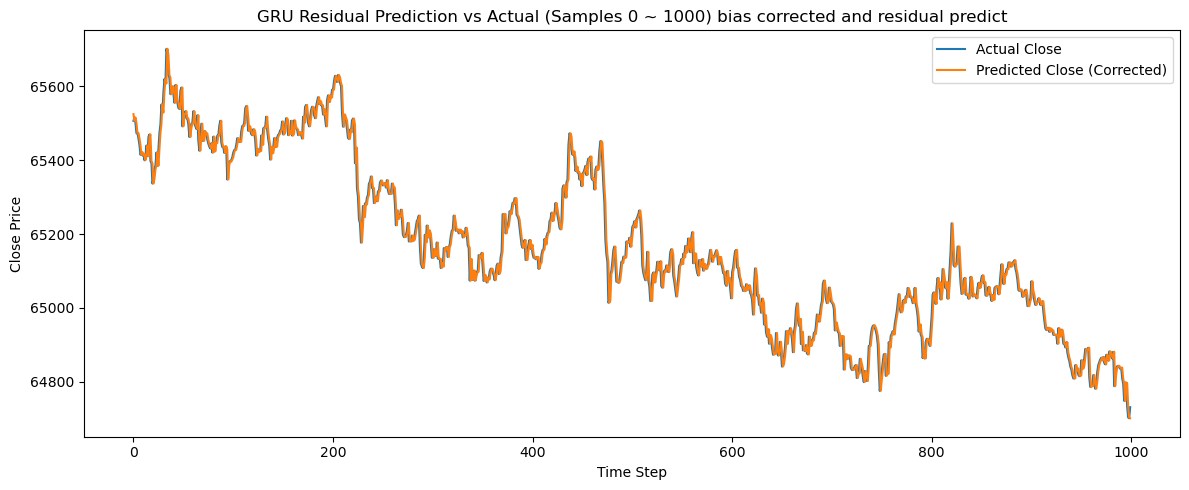

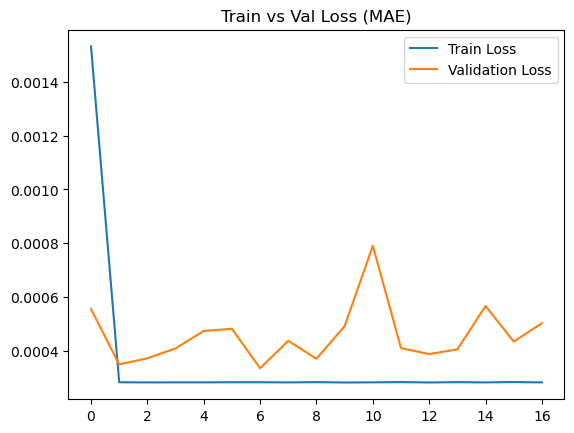

In [ ]:
#dropout 0,2->0.3; L2 0.001->0.002
model_gru_residual = build_gru_model_layer1_lossmae_L2v2(input_shape=(30, train_scaled2.shape[1]))

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_gru_residual = model_gru_residual.fit(
    X_train_gru_residual, y_train_gru_residual,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


rmse_tmp, mae_tmp = evaluate_gru_model_residual(
    model_gru_residual, 
    X_test_gru_residual, 
    y_test_gru_residual, 
    scaler, 
    close_index=0,
    n_plot=1000
)
plt.plot(history_gru_residual.history['loss'], label='Train Loss')
plt.plot(history_gru_residual.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Train vs Val Loss (MAE)")
plt.show()

#save results
model_cur_name = "GRU_1layer_lossmae_batch128_BiascorrectedandResidual_splitfirst_L2v2"
model_gru_residual.save(f"models/{model_cur_name}.h5")
save_model_parameters(
    model_name=model_cur_name,
    parameters={
        "window_size": 30,
        "loss": "mae",
        "gru_layers": 1,
        "Dense": 1,
        "units_per_layer": 64,
        "dropout": 0.3,
        "batch_size": 128,
        "epochs": 50
    }
)
log_model_performance(
    model_name=model_cur_name,
    metrics={
        "RMSE": rmse_tmp,
        "MAE": mae_tmp
    }
)

In [ ]:
#change sliding window step 1->3
def create_sliding_window_residual_splitfirst2_step(data, window_size=30, close_index=0, step=3):
    X, y = [], []
    for i in range(0, len(data) - window_size, step):
        window = data[i:i + window_size]
        close_t = data[i + window_size][close_index]
        close_t_1 = data[i + window_size - 1][close_index]
        y.append(close_t - close_t_1)
        X.append(window)
    return np.array(X), np.array(y)


close_index = 0
X_train_gru_residual_step, y_train_gru_residual_step = create_sliding_window_residual_splitfirst2_step(train_scaled2, window_size=30, close_index=0, step=3)
X_test_gru_residual_step, y_test_gru_residual_step = create_sliding_window_residual_splitfirst2_step(test_scaled2, window_size=30, close_index=0, step=3)

d:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
4893/4893 ━━━━━━━━━━━━━━━━━━━━ 79s 16ms/step - loss: 0.0159 - val_loss: 3.6004e-04
Epoch 2/50
4893/4893 ━━━━━━━━━━━━━━━━━━━━ 74s 15ms/step - loss: 3.0966e-04 - val_loss: 3.0060e-04
Epoch 3/50
4893/4893 ━━━━━━━━━━━━━━━━━━━━ 74s 15ms/step - loss: 2.8935e-04 - val_loss: 3.0023e-04
Epoch 4/50
4893/4893 ━━━━━━━━━━━━━━━━━━━━ 74s 15ms/step - loss: 2.9413e-04 - val_loss: 3.2680e-04
Epoch 5/50
4893/4893 ━━━━━━━━━━━━━━━━━━━━ 75s 15ms/step - loss: 2.8815e-04 - val_loss: 3.1134e-04
Epoch 6/50
4893/4893 ━━━━━━━━━━━━━━━━━━━━ 74s 15ms/step - loss: 2.9175e-04 - val_loss: 2.9039e-04
Epoch 7/50
4893/4893 ━━━━━━━━━━━━━━━━━━━━ 74s 15ms/step - loss: 2.9038e-04 - val_loss: 3.3607e-04
Epoch 8/50
4893/4893 ━━━━━━━━━━━━━━━━━━━━ 74s 15ms/step - loss: 2.8955e-04 - val_loss: 3.2954e-04
Epoch 9/50
4893/4893 ━━━━━━━━━━━━━━━━━━━━ 74s 15ms/step - loss: 2.8986e-04 - val_loss: 2.9415e-04
Epoch 10/50
4893/4893 ━━━━━━━━━━━━━━━━━━━━ 74s 15ms/step - loss: 2.8921e-04 - val_loss: 2.9976e-04
Epoch 11/50
4893/4893 ━

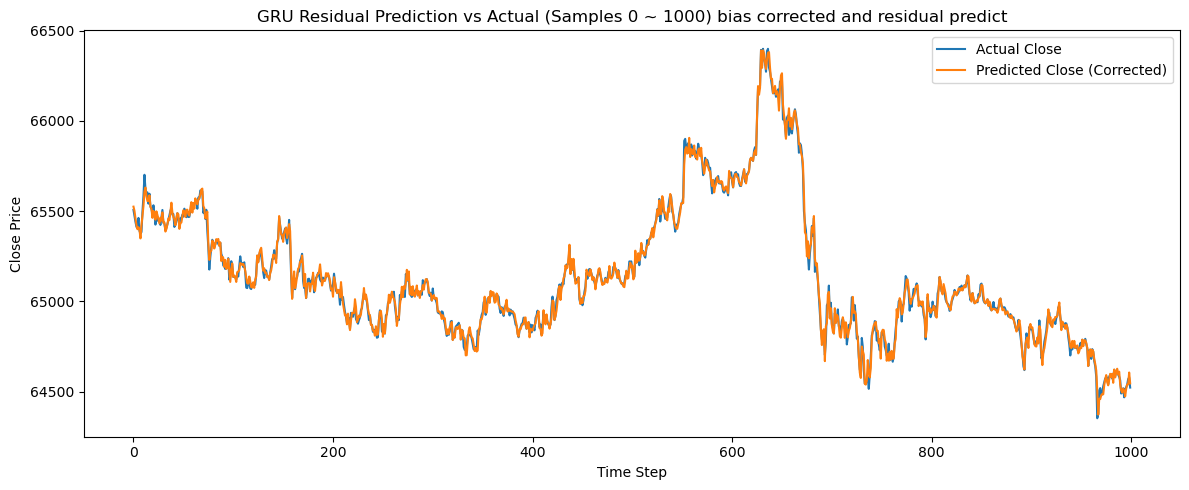

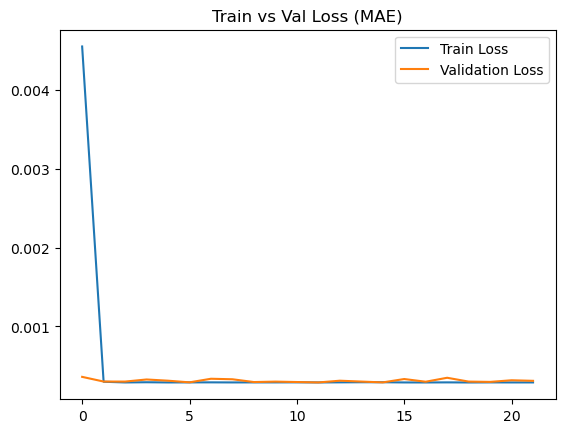

In [20]:
model_gru_residual = build_gru_model_layer1_lossmae_L2v2(input_shape=(30, train_scaled2.shape[1]))

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_gru_residual = model_gru_residual.fit(
    X_train_gru_residual_step, y_train_gru_residual_step,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


rmse_tmp, mae_tmp = evaluate_gru_model_residual(
    model_gru_residual, 
    X_test_gru_residual_step, 
    y_test_gru_residual_step, 
    scaler, 
    close_index=0,
    n_plot=1000
)
plt.plot(history_gru_residual.history['loss'], label='Train Loss')
plt.plot(history_gru_residual.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Train vs Val Loss (MAE)")
plt.show()

#save results
model_cur_name = "GRU_1layer_lossmae_batch128_BiascorrectedandResidual_splitfirst_L2v2_step"
model_gru_residual.save(f"models/{model_cur_name}.h5")
save_model_parameters(
    model_name=model_cur_name,
    parameters={
        "window_size": 30,
        "loss": "mae",
        "gru_layers": 1,
        "Dense": 1,
        "units_per_layer": 64,
        "dropout": 0.3,
        "batch_size": 128,
        "epochs": 50
    }
)
log_model_performance(
    model_name=model_cur_name,
    metrics={
        "RMSE": rmse_tmp,
        "MAE": mae_tmp
    }
)

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from tensorflow.keras import regularizers


# increase L2 0.001->0.002
def build_gru_model_layer1_lossmae_L2v2(input_shape):
    model = Sequential([
        GRU(64, return_sequences=False, input_shape=input_shape,
            kernel_regularizer=regularizers.l2(0.002)),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae')
    return model

d:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
4893/4893 ━━━━━━━━━━━━━━━━━━━━ 67s 13ms/step - loss: 0.0129 - val_loss: 3.4972e-04
Epoch 2/50
4893/4893 ━━━━━━━━━━━━━━━━━━━━ 61s 12ms/step - loss: 3.0176e-04 - val_loss: 3.1355e-04
Epoch 3/50
4893/4893 ━━━━━━━━━━━━━━━━━━━━ 63s 13ms/step - loss: 2.9009e-04 - val_loss: 3.1892e-04
Epoch 4/50
4893/4893 ━━━━━━━━━━━━━━━━━━━━ 63s 13ms/step - loss: 2.9010e-04 - val_loss: 2.9577e-04
Epoch 5/50
4893/4893 ━━━━━━━━━━━━━━━━━━━━ 62s 13ms/step - loss: 2.8942e-04 - val_loss: 2.9362e-04
Epoch 6/50
4893/4893 ━━━━━━━━━━━━━━━━━━━━ 63s 13ms/step - loss: 2.8893e-04 - val_loss: 3.0127e-04
Epoch 7/50
4893/4893 ━━━━━━━━━━━━━━━━━━━━ 62s 13ms/step - loss: 2.8862e-04 - val_loss: 3.1522e-04
Epoch 8/50
4893/4893 ━━━━━━━━━━━━━━━━━━━━ 63s 13ms/step - loss: 2.9012e-04 - val_loss: 3.0496e-04
Epoch 9/50
4893/4893 ━━━━━━━━━━━━━━━━━━━━ 63s 13ms/step - loss: 2.8969e-04 - val_loss: 3.0901e-04
Epoch 10/50
4893/4893 ━━━━━━━━━━━━━━━━━━━━ 63s 13ms/step - loss: 2.8964e-04 - val_loss: 3.0357e-04
Epoch 11/50
4893/4893 ━

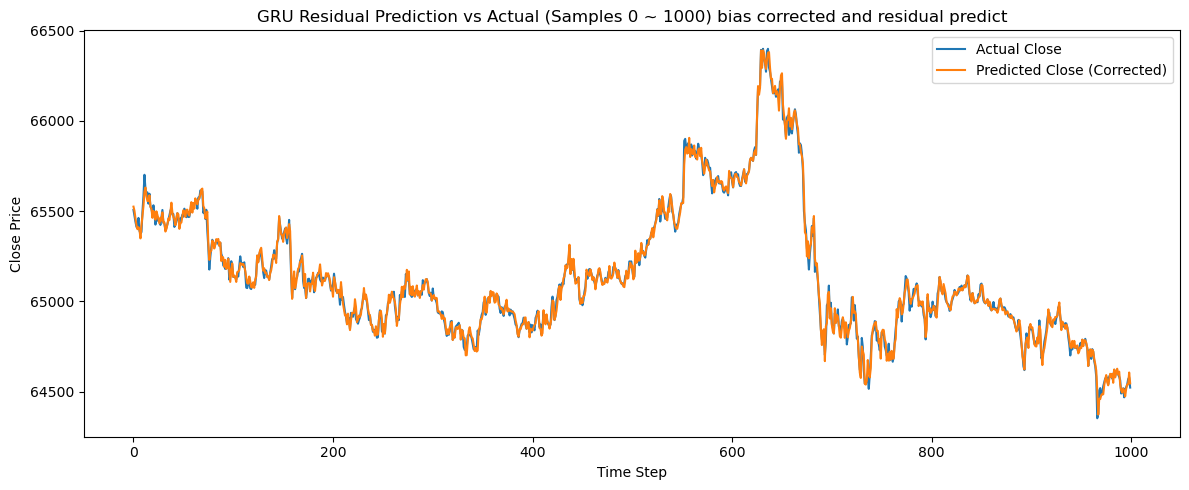

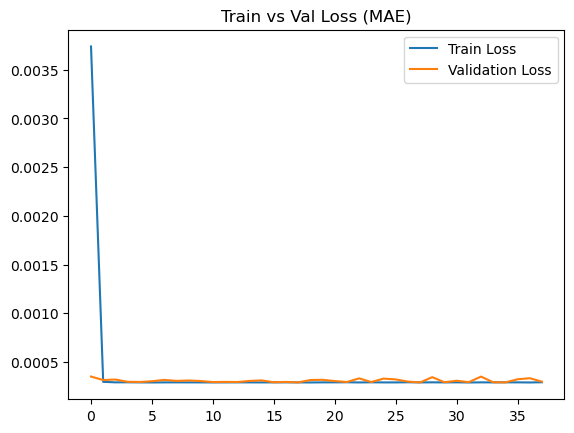

In [5]:
from sklearn.preprocessing import MinMaxScaler

# split dataset first
split_index = int(len(bitstamp_selected) * 0.8)
train_raw = bitstamp_selected.iloc[:split_index]
test_raw = bitstamp_selected.iloc[split_index:]

scaler = MinMaxScaler()
train_scaled2 = scaler.fit_transform(train_raw.values)
test_scaled2 = scaler.transform(test_raw.values)

def create_sliding_window_residual_splitfirst2_step(data, window_size=30, close_index=0, step=3):
    X, y = [], []
    for i in range(0, len(data) - window_size, step):
        window = data[i:i + window_size]
        close_t = data[i + window_size][close_index]
        close_t_1 = data[i + window_size - 1][close_index]
        y.append(close_t - close_t_1)
        X.append(window)
    return np.array(X), np.array(y)


close_index = 0
X_train_gru_residual_step, y_train_gru_residual_step = create_sliding_window_residual_splitfirst2_step(train_scaled2, window_size=30, close_index=0, step=3)
X_test_gru_residual_step, y_test_gru_residual_step = create_sliding_window_residual_splitfirst2_step(test_scaled2, window_size=30, close_index=0, step=3)

def evaluate_gru_model_residual(model, X_test, y_test, scaler, close_index=0, start=0, n_plot=1000):
    y_pred_residual = model.predict(X_test).flatten()

    last_close_norm = X_test[:, -1, close_index]
    y_pred_norm = y_pred_residual + last_close_norm
    y_test_norm = y_test + last_close_norm

    min_close = scaler.data_min_[close_index]
    max_close = scaler.data_max_[close_index]

    y_pred_real = y_pred_norm * (max_close - min_close) + min_close
    y_test_real = y_test_norm * (max_close - min_close) + min_close


    bias = np.mean(y_test_real - y_pred_real)
    y_pred_corrected = y_pred_real + bias

    rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_corrected))
    mae = mean_absolute_error(y_test_real, y_pred_corrected)

    print(f"[Corrected] RMSE: {rmse:.2f}")
    print(f"[Corrected] MAE : {mae:.2f}")

    end = start + n_plot
    plt.figure(figsize=(12, 5))
    plt.plot(y_test_real[start:end], label='Actual Close')
    plt.plot(y_pred_corrected[start:end], label='Predicted Close (Corrected)')
    plt.title(f'GRU Residual Prediction vs Actual (Samples {start} ~ {end}) bias corrected and residual predict')
    plt.xlabel('Time Step')
    plt.ylabel('Close Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return rmse, mae

def save_model_parameters(model_name, parameters, directory="parameters"):
    import os, json
    os.makedirs(directory, exist_ok=True)
    param_path = os.path.join(directory, f"{model_name}_params.json")
    with open(param_path, "w") as f:
        json.dump(parameters, f, indent=4)

def log_model_performance(model_name, metrics, log_file="performance/performance_log.csv"):
    import os, pandas as pd
    from datetime import datetime

    os.makedirs("performance", exist_ok=True)
    metrics["Model Name"] = model_name
    metrics["Timestamp"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    column_order = ["Timestamp", "Model Name"] + [col for col in metrics if col not in ["Timestamp", "Model Name"]]

    if not os.path.exists(log_file):
        df = pd.DataFrame(columns=column_order)
    else:
        df = pd.read_csv(log_file)

    new_row = pd.DataFrame([metrics])[column_order]
    df = pd.concat([df, new_row], ignore_index=True)

    df.to_csv(log_file, index=False)


model_gru_residual = build_gru_model_layer1_lossmae_L2v2(input_shape=(30, train_scaled2.shape[1]))

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_gru_residual = model_gru_residual.fit(
    X_train_gru_residual_step, y_train_gru_residual_step,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


rmse_tmp, mae_tmp = evaluate_gru_model_residual(
    model_gru_residual, 
    X_test_gru_residual_step, 
    y_test_gru_residual_step, 
    scaler, 
    close_index=0,
    n_plot=1000
)
plt.plot(history_gru_residual.history['loss'], label='Train Loss')
plt.plot(history_gru_residual.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Train vs Val Loss (MAE)")
plt.show()